In [2]:
# Stock Prediction, Neuraul Network Part
# Xin Wen, Group 3
import re
import numpy as np
import time
import math
import os
from keras import optimizers
from keras.layers import Embedding, SimpleRNN
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import tushare as ts

Using TensorFlow backend.


## Target stock
002456, 300002, 300713, 002340, 002673, 002302, 002230

In [44]:
s002230 =  pd.read_csv('002230.SZ.csv', header=0)
s002302 =  pd.read_csv('002302.SZ.csv', header=0)
s002673 =  pd.read_csv('002673.SZ.csv', header=0)
s002340 =  pd.read_csv('002340.SZ.csv', header=0)
s300002 =  pd.read_csv('300002.SZ.csv', header=0)
s002456 =  pd.read_csv('002456.SZ.csv', header=0)
def delnull(frame):
    return frame[frame.Open != 'null']
s002230 = delnull(s002230)
s002302 = delnull(s002302)
# s002673 = delnull(s002673)    # format error??
s002340 = delnull(s002340)
s300002 = delnull(s300002)
s002456 = delnull(s002456)
print(s002230)

            Date       Open       High        Low      Close  Adj Close  \
0     2011-01-04  13.856200  14.562100  13.856200  14.553400  14.268387   
15    2011-01-25  10.196100  10.387800   9.498910  10.387800  10.184366   
21    2011-02-09  10.811300  10.994300  10.635300  10.910700  10.697025   
22    2011-02-10  10.910700  11.607800  10.910700  11.255800  11.035367   
29    2011-02-21  11.773400  12.200400  11.644400  12.163800  11.925586   
38    2011-03-04  11.390900  11.524200  11.111100  11.461400  11.236941   
46    2011-03-16  12.954300  13.908500  12.954300  13.579100  13.313168   
50    2011-03-22  12.444400  12.577800  12.209200  12.287600  12.046959   
53    2011-03-25  12.316300  12.598700  12.248400  12.282300  12.041764   
56    2011-03-30  11.895400  12.068000  11.694100  11.694100  11.465084   
67    2011-04-18  11.398700  11.503300  11.058800  11.451000  11.226744   
69    2011-04-20  11.218300  11.803900  11.192200  11.686300  11.457436   
71    2011-04-22  11.8614

In [14]:
# this api can only get 3-year data
def concatdata(code):
    p1 = ts.get_hist_data(code,start='2012-01-04', end = '2014-1-3')
    p2 = ts.get_hist_data(code,start='2014-01-04', end = '2016-1-3')
    p3 = ts.get_hist_data(code,start='2012-01-04', end = '2014-1-3')
    p4 = ts.get_hist_data(code,start='2010-01-04', end = '2012-1-3')
    p5 = ts.get_hist_data(code,start='2008-01-04', end = '2010-1-3')
    print(p1)
    frames = [p1, p2, p3, p4, p5]
    result = pd.concat(frames)
    return result

# taiyue = concatdata('300002')


Empty DataFrame
Columns: [open, high, close, low, volume, price_change, p_change, ma5, ma10, ma20, v_ma5, v_ma10, v_ma20, turnover]
Index: []


In [85]:
def dataAugmentation(dataframe):
    close = dataframe['close']
    volume = dataframe['volume']
    open = dataframe['open']
    high = dataframe['high']
    low = dataframe['low']
    high = dataframe['high']
    priceChange = close - open
    pChange = high - low
    avgPrice5 = np.array(pd.DataFrame(np.pad(open, (4, 4), mode='edge')).rolling(5).mean())[4:-4]
    avgPrice10 = np.array(pd.DataFrame(np.pad(open, (9, 9), mode='edge')).rolling(5).mean())[9:-9]
    avgPrice30 = np.array(pd.DataFrame(np.pad(open, (29, 29), mode='edge')).rolling(5).mean())[29:-29]
    avgVolume5 = np.array(pd.DataFrame(np.pad(volume, (4, 4), mode='edge')).rolling(5).mean())[4:-4]
    avgVolume10 = np.array(pd.DataFrame(np.pad(volume, (9, 9), mode='edge')).rolling(5).mean())[9:-9]
    avgVolume30 = np.array(pd.DataFrame(np.pad(volume, (29, 29), mode='edge')).rolling(5).mean())[29:-29]
    dataframe.insert(6,'priceChange', priceChange)
    dataframe.insert(7, 'pChange', pChange)
    dataframe.insert(8, 'avgPrice5', avgPrice5)
    dataframe.insert(9, 'avgPrice10',avgPrice10)
    dataframe.insert(10, 'avgPrice30',avgPrice30)
    dataframe.insert(11, 'avgVolume5',avgVolume5)
    dataframe.insert(12, 'avgVolume10',avgVolume10)
    dataframe.insert(13, 'avgVolume30',avgVolume30)
    return dataframe
    

In [48]:
def normalization(X_train, X_test):
    # normalize data to 0-1
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    minmax = np.concatenate((X_train, X_test), axis=0)
    preprocessor = preprocessing.MinMaxScaler().fit(minmax)

    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [166]:
def preprocess_data(stock, time_window):
    amount_of_features = len(stock.columns) - 1
    data = stock.as_matrix()
    data = data[:, 1:]
    
    sequence_length = time_window + 1
    result = []
    for index in range(len(data) - sequence_length + 1):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(1.0 * result.shape[0]) -1      # change from 0.9 to 1.0
    train = result[: int(row), :]
    
    train, result = normalization(train, result)
    result = result[::-1, :, :]
    train = train[::-1, :, :]
    print(train.shape, result.shape)
    print(result[-10:])

    X_train = result[:-100, :, :]
    y_train = result[1:-99, :, 0]
    X_test = result[-100 :-1, :, :]        # only predict one day
    y_test = result[-99:, :, 0]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [73]:
# Data Augmentation
# prices_dataset = dataAugmentation(prices_dataset)
# s002230 = delnull(s002230)
# s002302 = delnull(s002302)
# s002340 = delnull(s002340)
# s300002 = delnull(s300002)
# s002456 = delnull(s002456)

(721, 7)
(720, 1, 6) (721, 1, 6)
[[[ 0.8289272   0.81009618  0.83679479  0.84740261  0.8475697   0.24295798]]

 [[ 0.84620889  0.81592328  0.86861974  0.85197424  0.85213632  0.20029504]]

 [[ 0.85857559  0.82264686  0.87792243  0.85150127  0.85166387  0.13973597]]

 [[ 0.85413627  0.81353267  0.85278888  0.85402354  0.85418338  0.19568978]]

 [[ 0.86079524  0.8090503   0.86943583  0.84551093  0.84568008  0.1069816 ]]

 [[ 0.8509653   0.80695852  0.84740308  0.8180812   0.81828039  0.16054341]]

 [[ 0.81434086  0.78469597  0.83238823  0.80515458  0.80536792  0.13909508]]

 [[ 0.8240122   0.78230538  0.83858998  0.8101991   0.81040692  0.09406682]]

 [[ 0.83035413  0.79201723  0.83679479  0.8330572   0.83323999  0.16914492]]

 [[ 0.84002555  0.81831387  0.85752178  0.85528471  0.85544316  0.21899658]]]
X_train (621, 1, 6)
y_train (621, 1)
X_test (99, 1, 6)
y_test (99, 1)
[[[ 0.6607082   0.62811128  0.65890107  0.63758119  0.63797802  0.38554249]]

 [[ 0.63597482  0.60465346  0.61646775 

c:\python36\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


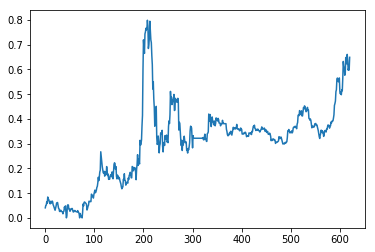

In [167]:
prices_dataset = s002230
print(prices_dataset.shape)
time_window = 0
X_train, y_train, X_test, y_test = preprocess_data(prices_dataset[:: -1], time_window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print(X_train[-5:])
plt.plot(y_train)
plt.show()

# Keras Optimizer
(this part is a memo of keras optimizer)
https://keras.io/optimizers/

SGD, stochastic gradient descent optimizer
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter updates momentum.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.

RMSProp optimizer
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor.
decay: float >= 0. Learning rate decay over each update.

keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
lr: float >= 0. Learning rate.
epsilon: float >= 0.
decay: float >= 0. Learning rate decay over each update.

keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
lr: float >= 0. Learning rate. It is recommended to leave it at the default value.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor.
decay: float >= 0. Learning rate decay over each update.

keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
lr: float >= 0. Learning rate.
beta_1: float, 0 < beta < 1. Generally close to 1.
beta_2: float, 0 < beta < 1. Generally close to 1.
epsilon: float >= 0. Fuzz factor.
decay: float >= 0. Learning rate decay over each update.

# Basic Neural Network
The following function is for basic neural network



In [91]:
def build_model_SNN(layers):
    model = Sequential()
    model.add(Dense(layers[1], input_dim=layers[0], activation='relu'))
    model.add(Dropout(0.3))
    for l in layers[1:]:
        model.add(Dense(l, activation='relu'))
        if l>=64:
            model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

# RNN
the following function build an RNN model

In [174]:
def build_model_RNN(layers):
    model = Sequential()
    model.add(SimpleRNN(256, activation='tanh', use_bias=True, input_shape=(None, layers[0])))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

model_RNN = build_model_RNN([X_train.shape[2]])

# LSTM
The following function is for building LSTM

keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)

units: Positive integer, dimensionality of the output space.

In [168]:
def build_model_LSTM(layers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(None, layers[0]),  return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1))
    model.add(Activation("linear"))
    opt = optimizers.Adam(lr=0.001)
    model.compile(loss="mse", optimizer=opt, metrics=['accuracy'])
    return model
model_LSTM = build_model_LSTM([X_train.shape[2]])

In [175]:
model_RNN.fit(
    X_train,
    y_train,
    batch_size=2048,
    epochs=400,
    validation_split=0.2,  # Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it
    verbose=2)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

Train on 496 samples, validate on 125 samples
Epoch 1/400
1s - loss: 0.0941 - acc: 0.0020 - val_loss: 0.1241 - val_acc: 0.0000e+00
Epoch 2/400
0s - loss: 0.0589 - acc: 0.0020 - val_loss: 0.0775 - val_acc: 0.0000e+00
Epoch 3/400
0s - loss: 0.0357 - acc: 0.0020 - val_loss: 0.0379 - val_acc: 0.0000e+00
Epoch 4/400
0s - loss: 0.0168 - acc: 0.0020 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 5/400
0s - loss: 0.0062 - acc: 0.0020 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 6/400
0s - loss: 0.0029 - acc: 0.0020 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 7/400
0s - loss: 0.0048 - acc: 0.0020 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 8/400
0s - loss: 0.0096 - acc: 0.0020 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 9/400
0s - loss: 0.0146 - acc: 0.0020 - val_loss: 0.0186 - val_acc: 0.0000e+00
Epoch 10/400
0s - loss: 0.0180 - acc: 0.0020 - val_loss: 0.0204 - val_acc: 0.0000e+00
Epoch 11/400
0s - loss: 0.0190 - acc: 0.0020 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 12/400
0s -

0s - loss: 3.8315e-04 - acc: 0.0020 - val_loss: 7.9718e-05 - val_acc: 0.0000e+00
Epoch 95/400
0s - loss: 3.8259e-04 - acc: 0.0020 - val_loss: 7.9775e-05 - val_acc: 0.0000e+00
Epoch 96/400
0s - loss: 3.8275e-04 - acc: 0.0020 - val_loss: 8.0587e-05 - val_acc: 0.0000e+00
Epoch 97/400
0s - loss: 3.8333e-04 - acc: 0.0020 - val_loss: 8.1490e-05 - val_acc: 0.0000e+00
Epoch 98/400
0s - loss: 3.8394e-04 - acc: 0.0020 - val_loss: 8.1934e-05 - val_acc: 0.0000e+00
Epoch 99/400
0s - loss: 3.8425e-04 - acc: 0.0020 - val_loss: 8.1683e-05 - val_acc: 0.0000e+00
Epoch 100/400
0s - loss: 3.8411e-04 - acc: 0.0020 - val_loss: 8.0859e-05 - val_acc: 0.0000e+00
Epoch 101/400
0s - loss: 3.8359e-04 - acc: 0.0020 - val_loss: 7.9829e-05 - val_acc: 0.0000e+00
Epoch 102/400
0s - loss: 3.8289e-04 - acc: 0.0020 - val_loss: 7.9007e-05 - val_acc: 0.0000e+00
Epoch 103/400
0s - loss: 3.8228e-04 - acc: 0.0020 - val_loss: 7.8678e-05 - val_acc: 0.0000e+00
Epoch 104/400
0s - loss: 3.8192e-04 - acc: 0.0020 - val_loss: 7.8886e

0s - loss: 3.7672e-04 - acc: 0.0020 - val_loss: 7.0832e-05 - val_acc: 0.0000e+00
Epoch 196/400
0s - loss: 3.7666e-04 - acc: 0.0020 - val_loss: 7.0767e-05 - val_acc: 0.0000e+00
Epoch 197/400
0s - loss: 3.7660e-04 - acc: 0.0020 - val_loss: 7.0702e-05 - val_acc: 0.0000e+00
Epoch 198/400
0s - loss: 3.7653e-04 - acc: 0.0020 - val_loss: 7.0637e-05 - val_acc: 0.0000e+00
Epoch 199/400
0s - loss: 3.7647e-04 - acc: 0.0020 - val_loss: 7.0571e-05 - val_acc: 0.0000e+00
Epoch 200/400
0s - loss: 3.7641e-04 - acc: 0.0020 - val_loss: 7.0505e-05 - val_acc: 0.0000e+00
Epoch 201/400
0s - loss: 3.7634e-04 - acc: 0.0020 - val_loss: 7.0438e-05 - val_acc: 0.0000e+00
Epoch 202/400
0s - loss: 3.7628e-04 - acc: 0.0020 - val_loss: 7.0371e-05 - val_acc: 0.0000e+00
Epoch 203/400
0s - loss: 3.7622e-04 - acc: 0.0020 - val_loss: 7.0303e-05 - val_acc: 0.0000e+00
Epoch 204/400
0s - loss: 3.7615e-04 - acc: 0.0020 - val_loss: 7.0235e-05 - val_acc: 0.0000e+00
Epoch 205/400
0s - loss: 3.7609e-04 - acc: 0.0020 - val_loss: 7.

0s - loss: 3.7054e-04 - acc: 0.0020 - val_loss: 6.4493e-05 - val_acc: 0.0000e+00
Epoch 288/400
0s - loss: 3.7047e-04 - acc: 0.0020 - val_loss: 6.4421e-05 - val_acc: 0.0000e+00
Epoch 289/400
0s - loss: 3.7040e-04 - acc: 0.0020 - val_loss: 6.4350e-05 - val_acc: 0.0000e+00
Epoch 290/400
0s - loss: 3.7033e-04 - acc: 0.0020 - val_loss: 6.4279e-05 - val_acc: 0.0000e+00
Epoch 291/400
0s - loss: 3.7026e-04 - acc: 0.0020 - val_loss: 6.4207e-05 - val_acc: 0.0000e+00
Epoch 292/400
0s - loss: 3.7019e-04 - acc: 0.0020 - val_loss: 6.4136e-05 - val_acc: 0.0000e+00
Epoch 293/400
0s - loss: 3.7012e-04 - acc: 0.0020 - val_loss: 6.4064e-05 - val_acc: 0.0000e+00
Epoch 294/400
0s - loss: 3.7005e-04 - acc: 0.0020 - val_loss: 6.3993e-05 - val_acc: 0.0000e+00
Epoch 295/400
0s - loss: 3.6998e-04 - acc: 0.0020 - val_loss: 6.3922e-05 - val_acc: 0.0000e+00
Epoch 296/400
0s - loss: 3.6991e-04 - acc: 0.0020 - val_loss: 6.3850e-05 - val_acc: 0.0000e+00
Epoch 297/400
0s - loss: 3.6983e-04 - acc: 0.0020 - val_loss: 6.

0s - loss: 3.6416e-04 - acc: 0.0020 - val_loss: 5.8182e-05 - val_acc: 0.0000e+00
Epoch 376/400
0s - loss: 3.6408e-04 - acc: 0.0020 - val_loss: 5.8111e-05 - val_acc: 0.0000e+00
Epoch 377/400
0s - loss: 3.6401e-04 - acc: 0.0020 - val_loss: 5.8039e-05 - val_acc: 0.0000e+00
Epoch 378/400
0s - loss: 3.6394e-04 - acc: 0.0020 - val_loss: 5.7968e-05 - val_acc: 0.0000e+00
Epoch 379/400
0s - loss: 3.6386e-04 - acc: 0.0020 - val_loss: 5.7897e-05 - val_acc: 0.0000e+00
Epoch 380/400
0s - loss: 3.6379e-04 - acc: 0.0020 - val_loss: 5.7825e-05 - val_acc: 0.0000e+00
Epoch 381/400
0s - loss: 3.6371e-04 - acc: 0.0020 - val_loss: 5.7754e-05 - val_acc: 0.0000e+00
Epoch 382/400
0s - loss: 3.6364e-04 - acc: 0.0020 - val_loss: 5.7683e-05 - val_acc: 0.0000e+00
Epoch 383/400
0s - loss: 3.6357e-04 - acc: 0.0020 - val_loss: 5.7611e-05 - val_acc: 0.0000e+00
Epoch 384/400
0s - loss: 3.6349e-04 - acc: 0.0020 - val_loss: 5.7540e-05 - val_acc: 0.0000e+00
Epoch 385/400
0s - loss: 3.6342e-04 - acc: 0.0020 - val_loss: 5.

In [176]:
def training_info(model):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train: %.4f MSE' % (trainScore[0]))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.4f MSE ' % (testScore[0]))
    return trainScore, testScore
    
trainScore, testScore = training_info(model_RNN)

Train: 0.0003 MSE
Test Score: 0.0004 MSE 


In [177]:
diff = []
ratio = []
pred = model_RNN.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))
print(pred)
print(y_test)
print((pred[0][0] -y_test[0][0]) / y_test[0][0])

# print(X_train)
# print(y_train)

[[ 0.64296275]
 [ 0.64505386]
 [ 0.63870746]
 [ 0.68714225]
 [ 0.73469764]
 [ 0.77217507]
 [ 0.8116017 ]
 [ 0.81456745]
 [ 0.84154624]
 [ 0.83330655]
 [ 0.81271142]
 [ 0.80582935]
 [ 0.83180988]
 [ 0.81274414]
 [ 0.76131725]
 [ 0.76531255]
 [ 0.76877809]
 [ 0.78625655]
 [ 0.79269785]
 [ 0.80407059]
 [ 0.79218608]
 [ 0.80192125]
 [ 0.76294386]
 [ 0.73853976]
 [ 0.75224805]
 [ 0.75735056]
 [ 0.73951536]
 [ 0.72142565]
 [ 0.72605193]
 [ 0.75092989]
 [ 0.75155216]
 [ 0.72781259]
 [ 0.71410418]
 [ 0.72145784]
 [ 0.70629776]
 [ 0.70979685]
 [ 0.7179873 ]
 [ 0.71947587]
 [ 0.7400142 ]
 [ 0.75563896]
 [ 0.75556058]
 [ 0.74452156]
 [ 0.74743307]
 [ 0.73541772]
 [ 0.68345773]
 [ 0.65581071]
 [ 0.65946317]
 [ 0.66288245]
 [ 0.67255807]
 [ 0.66738135]
 [ 0.6785028 ]
 [ 0.67671335]
 [ 0.66863763]
 [ 0.69014299]
 [ 0.7157135 ]
 [ 0.72112864]
 [ 0.75538868]
 [ 0.77602118]
 [ 0.77703595]
 [ 0.81239676]
 [ 0.80964512]
 [ 0.80448568]
 [ 0.80523312]
 [ 0.84525442]
 [ 0.91159248]
 [ 0.88043875]
 [ 0.91836

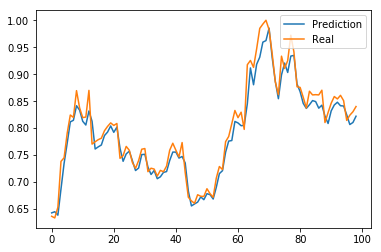

In [180]:
plt.plot(pred, label='Prediction')
plt.plot(y_test,  label='Real')
plt.legend(loc='upper right')
plt.show()

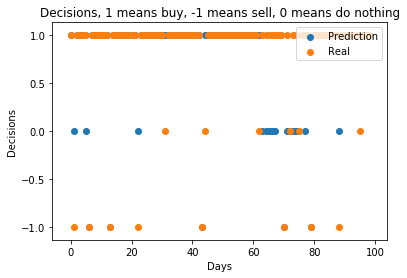

Accuracy 0.8282828282828283


In [179]:
def decision(X_test, pred, y_test):
    realDecision = []
    predDecision = []
    for i, p in enumerate(X_test):
        curprice = p[0, 1]
        realprice = y_test[i]
        predprice = pred[i, 0]
        if 0.99*curprice<=realprice<=1.01*curprice:     # do nothing
            realDecision.append(0)
        elif 0.99*curprice>realprice:       # sell
            realDecision.append(-1)
        else:
            realDecision.append(1)          # buy
            
        if 0.99*curprice<=predprice<=1.01*curprice:     # do nothing
            predDecision.append(0)
        elif 0.99*curprice>realprice:       # sell
            predDecision.append(-1)
        else:
            predDecision.append(1)   
    correct = sum(realDecision[i]==predDecision[i] for i in range(len(realDecision)))
    correctRate = correct/len(realDecision)
    
    plt.scatter(range(len(realDecision)),predDecision, label='Prediction')
    plt.scatter(range(len(realDecision)), realDecision, label='Real')
    plt.legend(loc='upper right')
    plt.title('Decisions, 1 means buy, -1 means sell, 0 means do nothing')
    plt.xlabel('Days')
    plt.ylabel('Decisions')
    plt.show()
    print('Accuracy {}'.format(correctRate))
    
decision(X_test, pred, y_test)